# CycleGAN Intro

Let me start by giving credit where credit is due. I am following to a large degree [Amy Jang's notebook](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial) on the topic to learn how to work with TFRecords.

We'll start by making the necessary imports to work with the data and the models.

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

import os

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("TensorFlow Version: {}".format(tf.__version__))
print("TensorFlow Addons: {}".format(tfa.__version__))
print("Keras Version: {}".format(keras.__version__))

TensorFlow Version: 2.2.0
TensorFlow Addons: 0.11.2
Keras Version: 2.3.0-tf


## Working with TFRecord Data

Let's import the Monet paintings and the photos to transform.

In [58]:
DATA_DIR = os.path.join(os.getcwd(), "data")
MONET_DIR = os.path.join(DATA_DIR, "monet_tfrec")
PHOTO_DIR = os.path.join(DATA_DIR, "photo_tfrec")
monet_files = tf.io.gfile.glob(os.path.join(MONET_DIR, "*.tfrec"))
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_DIR, "*.tfrec"))

print("Number of Monet Painting TFRecords: {}".format(len(monet_files)))
print("Number of Photo TFRecords: {}".format(len(photo_files)))

Number of Monet Painting TFRecords: 5
Number of Photo TFRecords: 20


In [59]:
IMAGE_SIZE = [256, 256]

def decode_image(img):
    """
    Turns a serialized image (TFRecord) into a three-channel image tensor.
    """
    # Decompress the image.
    image = tf.image.decode_jpeg(img, channels=3)
    
    # Scale pixel values to the range [-1, 1].
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    # Shape the flattened image data as a 3-channel image.
    image = tf.reshape(image, [*IMAGE_SIZE, 3])

    return image

def read_tfrecord(example):
    """
    Extracts a single image out of a TFRecord.

    Arguments:
        example:    The TFRecord representation of the image.

    Returns:
        image:      The uncompressed image in 3-channel format.
    """
    # Describe the format of the TFRecord data.
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }

    # Parse out a single image's data from the TFRecord.
    example_img = tf.io.parse_single_example(example, tfrecord_format)

    # Transform the serialized record into an actual image.
    image = decode_image(example_img['image'])

    return image

def load_dataset(filenames):
    """
    Extracts all the images out of a list of TFRecord files and creates a Dataset object.

    Parameters:
        filenames:  A list of TFRecord files containing image data.

    Returns:
        dataset:    The Dataset that is created out of all the TFRecord files.
    """
    # Create a single TFRecordDataset object from all of the input file names.
    dataset = tf.data.TFRecordDataset(filenames)

    # The 'map' function applies the provided function to each sample in the TFRecordDataset.
    dataset = dataset.map(read_tfrecord)

    return dataset

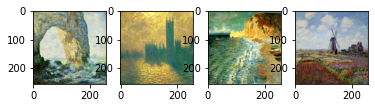

In [60]:
monet_dataset = load_dataset(monet_files).batch(4)
photo_dataset = load_dataset(photo_files).batch(4)

sample_monet = next(iter(monet_dataset))
sample_photo = next(iter(photo_dataset))

# Display the Monet examples.
plt.clf()
plt.subplot(141)
plt.imshow(sample_monet[0] * 0.5 + 0.5)
plt.subplot(142)
plt.imshow(sample_monet[1] * 0.5 + 0.5)
plt.subplot(143)
plt.imshow(sample_monet[2] * 0.5 + 0.5)
plt.subplot(144)
plt.imshow(sample_monet[3] * 0.5 + 0.5)

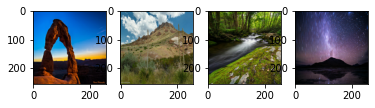

In [61]:
# Display the photo examples.
plt.clf()
plt.subplot(141)
plt.imshow(sample_photo[0] * 0.5 + 0.5)
plt.subplot(142)
plt.imshow(sample_photo[1] * 0.5 + 0.5)
plt.subplot(143)
plt.imshow(sample_photo[2] * 0.5 + 0.5)
plt.subplot(144)
plt.imshow(sample_photo[3] * 0.5 + 0.5)

## Build the Generator

The generator is implemented using the [UNET architecture](https://arxiv.org/pdf/1505.04597.pdf).  The UNET consists of a "contractive path" and "expansive path" with connections between the corresponding layers of each path.  The contractive path in this case is essentially a standard convolutional neural network where the input is reduced to a set of latent features.  The expansive path is the reverse of the contractive path, reconstructing the input from the latent feature vector at the "bottleneck".

Obviously, then, the essential pieces of this architecture will be downsampling (contractive) and upsampling (expansive).  These methods are defined below.

Note that instance normalization is used rather than batch normalization between the convolutional layer and the activation.  I had not heard of instance normalization before working through this notebook.  Here are two papers that describe it's advantages over batch normalization in this case:
- [Improved Texture Networks: Maximizing Quality and Diversity in Feed-forward Stylization and Texture Synthesis](https://arxiv.org/pdf/1701.02096.pdf)
- [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/pdf/1607.08022.pdf)

In [62]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    # Add a convolutional layer. This will reduce the dimensions of the input to
    # the layer by a factor of 2.
    result = keras.Sequential()
    result.add(
        layers.Conv2D(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False))

    # Add instance normalization.
    if apply_instancenorm:
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    # Use a leaky ReLU activation function.
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    # Expand the input dimensions by a factor of 2 by using a transpose convolution.
    result = keras.Sequential()
    result.add(
        layers.Conv2DTranspose(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False))
    
    # Apply instance normalization pre-activation.
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Regularize with dropout.
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())

    return result

In [63]:
IMAGE_DIMS = [*IMAGE_SIZE, OUTPUT_CHANNELS]

def Generator():
    contractive_path = [
        downsample(64, 4, apply_instancenorm=False),    # (N, 128, 128, 64)
        downsample(128, 4),                             # (N, 64, 64, 128)
        downsample(256, 4),                             # (N, 32, 32, 256)
        downsample(512, 4),                             # (N, 16, 16, 512)
        downsample(512, 4),                             # (N, 8, 8, 512)
        downsample(512, 4),                             # (N, 4, 4, 512)
        downsample(512, 4),                             # (N, 2, 2, 512)
        downsample(512, 4)  # This is the bottleneck.   # (N, 1, 1, 512)
    ]

    # Note that the number of channels in the expansive path includes the outputs
    # of the corresponding layer in the contractive path.
    expansive_path = [
        upsample(512, 4),   # (N, 2, 2, 1024)
        upsample(512, 4),   # (N, 4, 4, 1024)
        upsample(512, 4),   # (N, 8, 8, 1024)
        upsample(512, 4),   # (N, 16, 16, 1024)
        upsample(256, 4),   # (N, 32, 32, 512)
        upsample(128, 4),   # (N, 64, 64, 256)
        upsample(64, 4)     # (N, 128, 128, 128)
    ]

    input_layer = layers.Input(shape=[256, 256, 3])

    initializer = tf.random_normal_initializer(0.0, 0.02)
    output_layer = layers.Convolution2DTranspose(
        OUTPUT_CHANNELS, 4, strides=2, padding='same',
        kernel_initializer=initializer, activation='tanh') # (N, 256, 256, 3)

    x = input_layer

    # Connect the downsampling layers.
    skips = [] # Skip connections
    for layer in contractive_path:
        x = layer(x)
        skips.append(x)

    # Don't include the bottleneck layer in the skip connections.
    skips = reversed(skips[:-1])

    # Connect the layers in the expansive path and make the skip connections.
    for layer, skip in zip(expansive_path, skips):
        x = layer(x)
        x = layers.Concatenate()([x, skip])
    
    x = output_layer(x)

    return keras.Model(inputs=input_layer, outputs=x)

## Build the Discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [64]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_layer = layers.Input(shape=[256, 256, 3], name='input_image')

    down_1 = downsample(64, 4, False)(input_layer)      # (N, 128, 128, 64)
    down_2 = downsample(128, 4)(down_1)                 # (N, 64, 64, 128)
    down_3 = downsample(256, 4)(down_2)                 # (N, 32, 32, 256)

    zero_pad_1 = layers.ZeroPadding2D()(down_3)         # (N, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad_1)    # (N, 31, 31, 512)
    
    norm_1 = tfa.layers.InstanceNormalization(
        gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm_1)

    zero_pad_2 = layers.ZeroPadding2D()(leaky_relu)     # (N, 33, 33, 512)
    
    last = layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad_2)     # (N, 30, 30, 1)
    
    model = keras.Model(inputs=input_layer, outputs=last)

    return model

In [65]:
# Utilize TPUs if available.
strategy = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device: ", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

## Build the CycleGAN Model

Now we will stitch the generator and discriminator together to build and train the CycleGAN model.

In [67]:
class CycleGAN(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.monet_generator = monet_gen
        self.photo_generator = photo_gen
        self.monet_discriminator = monet_disc
        self.photo_discriminator = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Start by cycling the generators.

            # Generate a fake monet, then convert it back to a photo.
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)

            # Generate a fake photo, then convert it back to a Monet.
            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            same_monet = self.monet_generator(real_monet, training=True)
            same_photo = self.photo_generator(real_photo, training=True)

            # Now run the generated media through the discriminators.
            disc_real_monet = self.monet_discriminator(real_monet, training=True)
            disc_real_photo = self.photo_discriminator(real_photo, training=True)

            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

            # Evaluate loss for the generators.
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluate the total cycle loss.
            total_cycle_loss = \
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) \
                    + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # Evaluate total generator loss.
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss \
                + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss \
                + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluate loss for the discriminators.
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            # Calculate the gradients for the generator and discriminator.
            monet_gen_gradients = tape.gradient(
                total_monet_gen_loss, self.monet_generator.trainable_variables)
            photo_gen_gradients = tape.gradient(
                total_photo_gen_loss, self.photo_generator.trainable_variables)
            
            monet_disc_gradients = tape.gradient(
                monet_disc_loss, self.monet_discriminator.trainable_variables)
            photo_disc_gradients = tape.gradient(
                photo_disc_loss, self.photo_discriminator.trainable_variables)
            
            # Apply the gradients to the optimizers.
            self.monet_gen_optimizer.apply_gradients(
                zip(monet_gen_gradients, self.monet_generator.trainable_variables))
            self.photo_gen_optimizer.apply_gradients(
                zip(photo_gen_gradients, self.photo_generator.trainable_variables))
            self.monet_discriminator.apply_gradients(
                zip(monet_disc_gradients, self.monet_discriminator.trainable_variables))
            self.photo_discriminator.apply_gradients(
                zip(photo_disc_gradients, self.photo_discriminator.trainable_variables))
            
            return {
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss
            }